<a href="https://colab.research.google.com/github/PauloGunther/project_pos/blob/main/tcc_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introdução

### Considerações iniciais
O trabalho visa comparar o desemprenho de tres modelos de machine learning para prever os preços dos imóveis em Goinia-GO: SARIMAX - Modelo estatistico para séries temperais, XGBoost - Ensemble sequencial de arvores de decisão e LSTM - Rede neural para dados sequencias de longo prazo.

Para isso serão usados como variaveis indepentes 10 inidicadores macroeconomicos:

dolar - Média mensal de compra

tx_juros - Taxa média de juros das operações de crédito

ipca - Índice nacional de preços ao consumidor-amplo

renda_med - Rendimento médio real habitual das pessoas ocupadas

ocupado_rend - População ocupada com rendimento

incc - Indice de custo de construção geral (Mão de obra + Material)

ic_agro - Indice de preços de commodities focado apenas em agricolas

inadim_imob - inadimplencia imobiliaria PJ e PF

sald_cred - Saldo da carteira de crédito com recursos direcionados

vol_cred - Volume da carteira de crédito com recursos direcionados

### 1.2 Bibliotecas usadas e importação dos dados

In [63]:
# Bibliotecas gerais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt

# BIbliotecas de Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Padronizar/Normalizar features
from sklearn.metrics import mean_squared_error # Métricas (RMSE)
from sklearn.model_selection import train_test_split  # Divisao de dados
from statsmodels.tsa.stattools import ccf # para calcular a correlação cruzada

# Bibliotecas ARIMA
from statsmodels.tsa.stattools import adfuller # Teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorreções
from statsmodels.tsa.statespace.sarimax import SARIMAX # Modelo
import statsmodels.api as sm

# Bibliotecas XGBoost
import xgboost as xgb # Modelo
import shap # Peso das variaveis
from sklearn import tree # Visualizar arvore de decisao
from sklearn.model_selection import TimeSeriesSplit # Validação cruzada em séries temporais

# Outras
import itertools
import warnings
warnings.filterwarnings('ignore')

In [64]:
# Importar dataframe já pré-processado
url = "https://github.com/PauloGunther/project_pos/raw/refs/heads/main/df_pre_model.pkl"

df_pre_pro = pd.read_pickle(url)
df_pre_pro.tail()

,date,go_price,tx_juros,ipca,renda_med,ocupado_rend,incc,ic_agro,inadim_imob,vol_cred,sald_cred
133,2025-02-01,7974.0,30.56,5.057630,3335.0,99291.0,7.419134,510.22,1.146447,20534.0,1250719.0
134,2025-03-01,7982.0,31.25,5.477190,3347.0,99213.0,7.536965,484.87,1.206241,20244.0,1263677.0
135,2025-04-01,7936.0,31.53,5.529729,3331.0,99972.0,7.536965,494.59,1.234180,21813.0,1276366.0
136,2025-05-01,7905.0,31.56,5.319636,3342.0,100585.0,7.238429,491.25,1.241216,21979.0,1289912.0
137,2025-06-01,7886.0,31.52,5.351165,3369.0,101004.0,7.217132,476.21,1.121180,21873.0,1300442.0


In [65]:
# Transforma feature datetime em indice
df_pre_pro.set_index('date', inplace=True)

In [66]:
df_pre_pro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 2014-01-01 to 2025-06-01
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   go_price      138 non-null    float64
 1   tx_juros      138 non-null    float64
 2   ipca          138 non-null    float64
 3   renda_med     138 non-null    float64
 4   ocupado_rend  138 non-null    float64
 5   incc          138 non-null    float64
 6   ic_agro       138 non-null    float64
 7   inadim_imob   138 non-null    float64
 8   vol_cred      138 non-null    float64
 9   sald_cred     138 non-null    float64
dtypes: float64(10)
memory usage: 11.9 KB


# 2. SARIMAX


## 2.1 Análise da variavel dependente
Avaliando o preço do metro quadrado dos imóveis em Goiânia, observa-se que se trata de uma série temporal não estacionária, pois as principais estatísticas se alteram ao longo do tempo. O teste de estacionariedade de Dickey-Fuller confirmou essa característica, pois o nível de significância foi maior que 0,05, rejeitando a hipótese nula da série ser estacionaria. Assim, foram necessárias duas diferenciações para tornar a série estacionária, o que sugere o uso do parâmetro d=2 no modelo SARIMAX.

Em relação às funções de autocorrelação [ACF] e autocorrelação parcial [PACF], observou-se um declínio acentuado logo no primeiro “lag”, embora os valores iniciais tenham permanecido fora do intervalo de confiança, como observado na Figura 8 e Figura 9, respectivamente. O retorno aos limites de confiança ocorreu a partir do segundo “lag” em ambas as funções, indicando a possibilidade de adoção dos parâmetros p=2 e q=2 no modelo.


In [67]:
# Copiando df pré processado
df_sarimax = df_pre_pro.copy()

In [68]:
# Separando df em y e X
y = df_sarimax['go_price']  # preço dos imóveis R$/m²
X = df_sarimax.drop(columns=['go_price'])  # variáveis exógenas

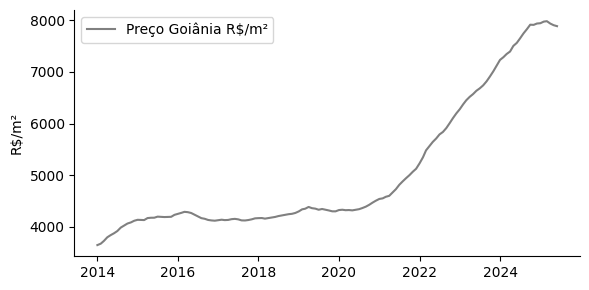

In [69]:
# Tamanho da figura
plt.figure(figsize=(6, 3))

# Plot da segunda série
plt.plot(df_sarimax.index, df_sarimax['go_price'], label='Preço Goiânia R$/m²', color ='grey')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

In [70]:
# Teste de estacionariedade do preço (Augmented Dickey-Fuller)
result = adfuller(y)
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('Não estacionária')
else:
    print('Estacionária')

p-value: 0.39987539806678524
Não estacionária


In [71]:
# Diferenciação multipla d=2
y_diff = y.diff().diff().dropna()

# Teste de estacionariedade do preço
result = adfuller(y_diff)
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print('Não estacionária')
else:
    print('Estacionária')

p-value: 2.341470663882069e-09
Estacionária


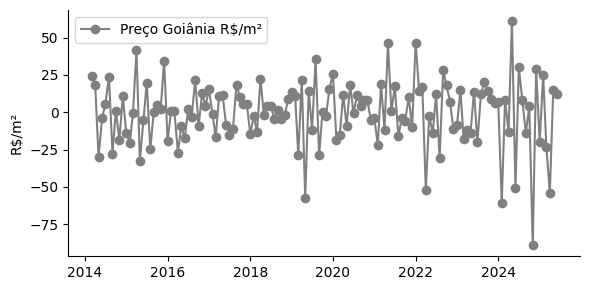

In [72]:
# Plot da série diferenciada d=2
plt.figure(figsize=(6, 3))

# Plot da segunda série
plt.plot(y_diff, marker='o', label='Preço Goiânia R$/m²', color ='grey')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

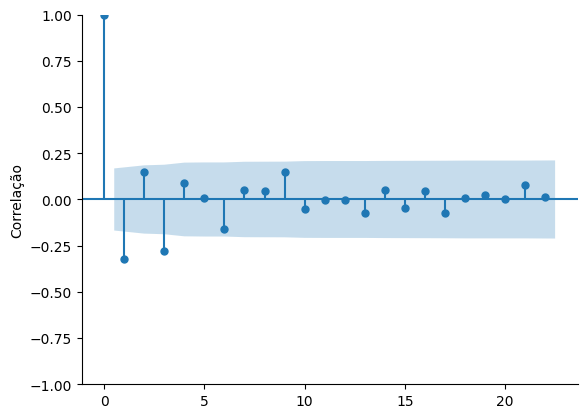

In [73]:
# Autocorrelação
plot_acf(y_diff, alpha = 0.05)

# Opções dos eixos
plt.ylabel('Correlação', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Titulo
plt.title('')

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

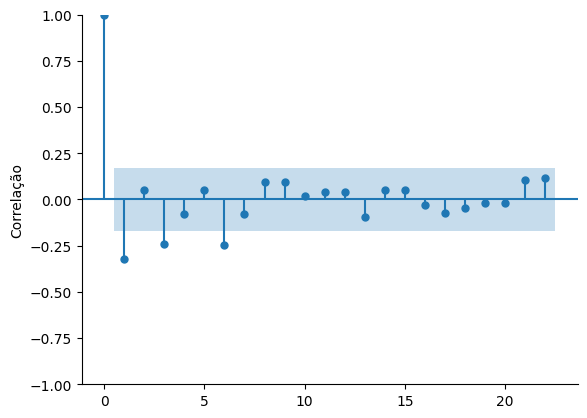

In [74]:
# Autocorrelação parcial
plot_pacf(y_diff, alpha = 0.05)

# Opções dos eixos
plt.ylabel('Correlação', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Titulo
plt.title('')

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

## 2.2 Ajustes variaveis independetes
Todas as dez variáveis explicativas foram testadas quanto à estacionariedade e precisaram ser diferenciadas antes de sua inclusão no modelo. Algumas variaveis precisaram uma segunda diferenciação.

Foram criadas variaveis defasadas 3 períodos e eliminado as variaveis contemporaneas a variavel resposta para não haver dataleakage.

Essas variaveis foram padronizadas usando o Z scaler, para os coeficientes poderem ser comparados, já que na forma orginal existe uma grande diferença de escalas.

Aqui foi definido o tamanho da amostra de teste (previsão) do modelo: 12 meses


In [75]:
# Teste de estacionaridade para cada uma das variaveis
for col in X.columns:
    result = adfuller(X[col])
    print(f'{col}: p-value = {result[1]}')

tx_juros: p-value = 0.14998490660175418
ipca: p-value = 0.11315675549840526
renda_med: p-value = 0.6296463779813326
ocupado_rend: p-value = 0.8137847449285941
incc: p-value = 0.21389747647989443
ic_agro: p-value = 0.9563702022551306
inadim_imob: p-value = 0.5071560158076804
vol_cred: p-value = 0.6979836820124001
sald_cred: p-value = 0.9987630432310369


In [76]:
# Diferenciar todas variaveis p-valor
X_copy = X.copy()

for col in X_copy.columns:
    X_copy[col] = X_copy[col].diff()

# Eliminar NaN
X_copy.dropna(inplace=True)

# Printar p-value ADF
for col in X_copy.columns:
    result = adfuller(X_copy[col])
    print(f'{col}: p-value = {result[1]}')


tx_juros: p-value = 0.06966866763262801
ipca: p-value = 0.011857680063458177
renda_med: p-value = 0.00016455957657795245
ocupado_rend: p-value = 0.030405756794609523
incc: p-value = 0.004381916362340789
ic_agro: p-value = 3.224569435680265e-16
inadim_imob: p-value = 2.3806899126309537e-07
vol_cred: p-value = 0.1519602745434337
sald_cred: p-value = 0.758402015445268


In [77]:
# Diferenciar novamente variaveis que nao passaram no ADF
X_copy['tx_juros'] = X_copy['tx_juros'].diff()
X_copy['vol_cred'] = X_copy['vol_cred'].diff()
X_copy['sald_cred'] = X_copy['sald_cred'].diff()

# Eliminar NaN
X_copy.dropna(inplace=True)

# Printar p-value ADF
for col in X_copy.columns:
    result = adfuller(X_copy[col])
    print(f'{col}: p-value = {result[1]}')

tx_juros: p-value = 0.0012499029416097108
ipca: p-value = 0.01029989264953793
renda_med: p-value = 0.0002615694026597388
ocupado_rend: p-value = 0.03065757787607261
incc: p-value = 0.0048215899000907565
ic_agro: p-value = 4.1485159783496053e-16
inadim_imob: p-value = 4.022887989093997e-07
vol_cred: p-value = 1.1881083198127637e-10
sald_cred: p-value = 0.1929213697594529


In [78]:
# Criar variaveis com lag

# Número de lags
lags = 3  # Lag

# Lag features
for col in X_copy.columns.tolist():
    for lag in range(1, lags + 1):
        X_copy[f'{col}_lag_{lag}'] = X_copy[col].shift(lag)

# Remover linhas com NaN (criadas pelos lags)
X_copy = X_copy.dropna()

# Excluir features no lag=0 - Evitar dataleakage
X_copy = X_copy.drop(columns=X.columns.tolist())

In [79]:
# Ajuste tamanho y e X - NaN por conta do lag
n_ajuste = lags
y_diff = y_diff.iloc[n_ajuste:]

In [80]:
# Padronizar variaveis X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_copy)
X_scaled

# Manter nomes originais
X_scaled = pd.DataFrame(X_scaled, columns=X_copy.columns, index=X_copy.index)
X_scaled.tail(10)

,tx_juros_lag_1,tx_juros_lag_2,tx_juros_lag_3,ipca_lag_1,ipca_lag_2,ipca_lag_3,renda_med_lag_1,renda_med_lag_2,renda_med_lag_3,ocupado_rend_lag_1,...,ic_agro_lag_3,inadim_imob_lag_1,inadim_imob_lag_2,inadim_imob_lag_3,vol_cred_lag_1,vol_cred_lag_2,vol_cred_lag_3,sald_cred_lag_1,sald_cred_lag_2,sald_cred_lag_3
date,,,,,,,,,,,,,,,,,,,,,
2024-09-01,-0.060767,-0.155661,0.212600,-0.471650,0.512619,0.562726,0.760734,-0.828659,0.937944,0.565930,...,2.157166,-0.003610,-0.259130,-0.694487,-0.064813,0.266424,-0.997711,0.041146,0.404132,-0.447783
2024-10-01,-0.060767,-0.060584,-0.155853,0.361722,-0.476512,0.505257,-0.534499,0.766444,-0.841325,0.636954,...,0.420472,-0.294439,-0.009209,-0.258039,-0.518978,-0.070430,0.280502,0.065432,0.041854,0.402885
2024-11-01,0.818740,-0.060584,-0.060768,0.633846,0.357121,-0.481001,0.611284,-0.529577,0.740247,0.718335,...,-1.287856,-0.050043,-0.299332,-0.008091,-0.070725,-0.524905,-0.054178,-0.584021,0.066145,0.040587
2024-12-01,-0.060767,0.818874,-0.060768,0.227297,0.629331,0.350211,0.511651,0.616903,-0.544780,0.358778,...,0.961245,0.181047,-0.055529,-0.298245,-0.311022,-0.076346,-0.505719,-0.138909,-0.583443,0.064880
2025-01-01,-0.464864,-0.060584,0.818765,-0.064201,0.222654,0.621630,0.760734,0.517209,0.591975,-0.281914,...,1.272349,-0.983485,0.175001,-0.054415,1.082772,-0.316807,-0.060055,-0.580671,-0.138239,-0.584744
2025-02-01,1.484313,-0.464660,-0.060768,-0.491704,-0.068935,0.216135,0.910184,0.766444,0.493127,-1.387219,...,2.094030,0.293618,-0.986704,0.176139,-1.051040,1.077936,-0.298964,-0.364186,-0.580092,-0.139515
2025-03-01,-0.845192,1.484409,-0.464878,0.939803,-0.496572,-0.074608,0.710918,0.915984,0.740247,-0.594122,...,3.504979,0.169024,0.287298,-0.985693,1.262560,-1.057329,1.086775,0.773926,-0.363563,-0.581394
2025-04-01,0.081856,-0.844966,1.484357,0.794272,0.935384,-0.501003,0.511651,0.716597,0.888520,-0.252321,...,0.331716,0.352449,0.163006,0.288448,-0.646951,1.257847,-1.034706,0.466159,0.774786,-0.364852
2025-05-01,-0.488635,0.082030,-0.845217,0.111215,0.789807,0.926794,-0.883216,0.517209,0.690823,0.986153,...,-2.745471,0.177369,0.345986,0.164143,0.644603,-0.652965,1.265525,-0.128022,0.466955,0.773560


In [81]:
# Tamanho da previsão
test_size = 12

# Ajuste do tabalho do teste
train_size = len(X_scaled)-test_size

## 2.3 Modelo Inicial
Seguindo os parâmetros sugeridos pela analisa temporal da variavel independete.



In [82]:
# Dividir em teste e treino
X_train, X_test = X_scaled.iloc[:-test_size], X_scaled.iloc[-test_size:]
y_train, y_test = y_diff.iloc[:-test_size], y_diff.iloc[-test_size:]

In [83]:
# 1º Modelo SARIMAX (com d=2)
modelo_arima_inicial = SARIMAX(
    y_train,
    exog=X_train,                  # Variáveis exógenas padronizadas
    order=(2, 0, 2),                # ARIMA(2, 0, 2)
    seasonal_order=(1, 0, 1, 12)    # Com sazonalidade
)

resultado_inicial = modelo_arima_inicial.fit()
print(resultado_inicial.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             go_price   No. Observations:                  121
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -489.169
Date:                              Mon, 01 Sep 2025   AIC                           1046.339
Time:                                      00:24:15   BIC                           1141.396
Sample:                                  06-01-2014   HQIC                          1084.945
                                       - 06-01-2024                                         
Covariance Type:                                opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
tx_juros_lag_1        -5.9732      2.654     -2.250      0.024     -11.176      -0

In [89]:
# Predição do modelo SARIMAX
forecast_steps = len(X_test)
forecast_inicial = resultado_inicial.get_forecast(steps=forecast_steps,
                              exog=X_test)

# Predição
y_pred_init_sarimax = forecast_inicial.predicted_mean

# Retornando diferenciação
y_reconst1 = y_pred_init_sarimax.cumsum() # diff1
y_reconst2 = y_reconst1.cumsum() # diff2

# Retorando valores reais
y_true_test = y.iloc[-len(y_pred_init_sarimax):]

# Terminando o retorno da diferenciação
y_reconst2 = y_reconst2 + (y_true_test[1] - y_true_test[0])
y_pred_init_sarimax = y_reconst2 + y_true_test[0]


# Calcular RMSE
rmse_inicial = sqrt(mean_squared_error(y_true_test, y_pred_init_sarimax))
print(f'RMSE: {rmse_inicial:.2f} - LL: {resultado_inicial.llf:.2f} - AIC: {resultado_inicial.aic:.2f}')


RMSE: 305.96 - LL: -489.17 - AIC: 1046.34


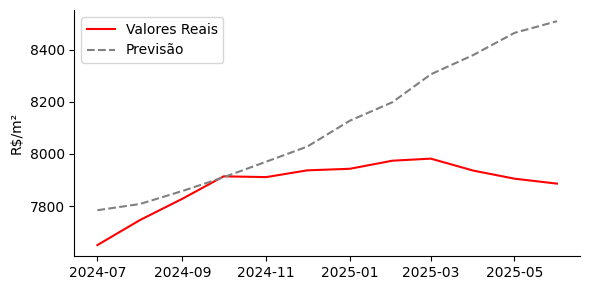

In [90]:
# Criar figura
plt.figure(figsize=(6, 3))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')

# Plotar valores previstos
plt.plot(y_test.index, y_pred_init_sarimax, '--', color='grey', label='Previsão')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()


## 2.4 Modelo com Grid Search - RMSE

Foi criado uma função para combinar parametros e encontrar o melhor RMSE. Foi criado um arquivo de funções chamado gridsearch e está sendo puxado do github.

Modelo rodado e realizado previsão do modelo.

Resultados de erro melhor que o modelo inicial.


In [91]:
# Puxando arquivo de funções gridsearch criado
!wget https://github.com/PauloGunther/project_pos/raw/refs/heads/main/gridsearch.py -O gridsearch.py

--2025-09-01 00:25:37--  https://github.com/PauloGunther/project_pos/raw/refs/heads/main/gridsearch.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/PauloGunther/project_pos/refs/heads/main/gridsearch.py [following]
--2025-09-01 00:25:37--  https://raw.githubusercontent.com/PauloGunther/project_pos/refs/heads/main/gridsearch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7739 (7.6K) [text/plain]
Saving to: ‘gridsearch.py’

gridsearch.py       100%[===================>]   7.56K  --.-KB/s    in 0s      

2025-09-01 00:25:37 (27.7 MB/s) - ‘gridsearch.py’ saved [7739/7739]



In [92]:
# Importando funções gridsearch RMSE e AIC
import gridsearch

In [94]:
# Gridsearch procurando melhor RMSE

#Função comentada pois demora para rodar
gridsearch.sarimax_gridsearch_rmse(y, y_train, y_test, exog_train=X_train, exog_test=X_test,
                           p_values=range(0, 3), d_values=range(0, 1), q_values=range(0, 3),
                           P_values=range(0, 3), D_values=range(0, 2), Q_values=range(0, 3),
                           seasonal_period=12)


SARIMAX(0, 0, 0)x(0, 0, 0, 12) - RMSE: 261.13 - AIC: 1070.32 - LL: -507.16
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - RMSE: 259.85 - AIC: 1072.16 - LL: -507.08
SARIMAX(0, 0, 0)x(0, 0, 2, 12) - RMSE: 237.59 - AIC: 1066.02 - LL: -503.01
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - RMSE: 334.07 - AIC: 1016.85 - LL: -480.43
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - RMSE: 393.60 - AIC: 992.09 - LL: -467.04
SARIMAX(0, 0, 0)x(0, 1, 2, 12) - RMSE: 396.23 - AIC: 992.03 - LL: -466.01
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - RMSE: 260.50 - AIC: 1072.22 - LL: -507.11
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - RMSE: 291.20 - AIC: 1067.55 - LL: -503.78
SARIMAX(0, 0, 0)x(1, 0, 2, 12) - RMSE: 266.32 - AIC: 1065.52 - LL: -501.76
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - RMSE: 316.23 - AIC: 1002.33 - LL: -472.16
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - RMSE: 394.50 - AIC: 993.38 - LL: -466.69
SARIMAX(0, 0, 0)x(1, 1, 2, 12) - RMSE: 440.79 - AIC: 991.96 - LL: -464.98
SARIMAX(0, 0, 0)x(2, 0, 0, 12) - RMSE: 247.55 - AIC: 1071.67 - LL: -505.84
SARIMAX(0, 0, 0)x(2, 0, 1, 12

,order,seasonal_order,rmse,log_likelihood,aic,bic
0,"(0, 0, 0)","(0, 0, 2, 12)",237.590499,-503.010231,1066.020462,1149.894179
1,"(0, 0, 0)","(2, 0, 0, 12)",247.552065,-505.835322,1071.670644,1155.544360
2,"(0, 0, 0)","(2, 0, 2, 12)",257.307780,-504.471980,1072.943961,1162.409258
3,"(0, 0, 0)","(0, 0, 1, 12)",259.853987,-507.080759,1072.161518,1153.239444
4,"(0, 0, 0)","(1, 0, 0, 12)",260.498924,-507.109645,1072.219291,1153.297216
...,...,...,...,...,...,...
157,"(2, 0, 0)","(2, 1, 2, 12)",530.450058,-449.452427,966.904855,1058.410683
158,"(1, 0, 1)","(1, 1, 2, 12)",539.997995,-451.631377,969.262754,1058.077234
159,"(2, 0, 0)","(1, 1, 2, 12)",545.832199,-451.932356,969.864713,1058.679193
160,"(1, 0, 1)","(2, 1, 2, 12)",548.894862,-449.227636,966.455271,1057.961099


In [95]:
# 2º Modelo SARIMAX - Grid Search - RMSE

"""
Top 5 melhores modelos por RMSE:
    order seasonal_order       rmse  log_likelihood         aic         bic
(0, 0, 0)  (0, 0, 2, 12) 237.590499     -503.010231 1066.020462 1149.894179
(0, 0, 0)  (2, 0, 0, 12) 247.552065     -505.835322 1071.670644 1155.544360
(0, 0, 0)  (2, 0, 2, 12) 257.307780     -504.471980 1072.943961 1162.409258
(0, 0, 0)  (0, 0, 1, 12) 259.853987     -507.080759 1072.161518 1153.239444
(0, 0, 0)  (1, 0, 0, 12) 260.498924     -507.109645 1072.219291 1153.297216
"""

# Modelo com o menor erro (RMSE)
modelo_arima_gs = SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 0, 0),
    seasonal_order=(0, 0, 2, 12))

# Treinar
resultado_gs = modelo_arima_gs.fit()
print(resultado_gs.summary())

                                   SARIMAX Results                                   
Dep. Variable:                      go_price   No. Observations:                  121
Model:             SARIMAX(0, 0, [1, 2], 12)   Log Likelihood                -503.010
Date:                       Mon, 01 Sep 2025   AIC                           1066.020
Time:                               00:55:31   BIC                           1149.894
Sample:                           06-01-2014   HQIC                          1100.085
                                - 06-01-2024                                         
Covariance Type:                         opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
tx_juros_lag_1        -2.2362      2.974     -0.752      0.452      -8.065       3.592
tx_juros_lag_2        -3.9627      3.618     -1.095

In [96]:
# Predição do modelo SARIMAX - Grid Search - RMSE
forecast_steps = len(X_test)
forecast_gs = resultado_gs.get_forecast(steps=forecast_steps,
                              exog=X_test)

# Previsão
y_pred_gs_rmse = forecast_gs.predicted_mean

# Retornando diferenciação
y_reconst1 = y_pred_gs_rmse .cumsum() # diff1
y_reconst2 = y_reconst1.cumsum() # diff2

# Terminando o retorno da diferenciação
y_reconst2 = y_reconst2 + (y_true_test[1] - y_true_test[0])
y_pred_gs_rmse  = y_reconst2 + y_true_test[0]

# Calcular RMSE
rmse_gs = sqrt(mean_squared_error(y_true_test, y_pred_gs_rmse))


print('INICIAL')
print(f'RMSE: {rmse_inicial:.2f} - LL: {resultado_inicial.llf:.2f} - AIC: {resultado_inicial.aic:.2f}')
print('Grid Search RMSE:')
print(f'RMSE: {rmse_gs:.2f} - LL: {resultado_gs.llf:.2f} - AIC: {resultado_gs.aic:.2f}')


INICIAL
RMSE: 305.96 - LL: -489.17 - AIC: 1046.34
Grid Search RMSE:
RMSE: 237.59 - LL: -503.01 - AIC: 1066.02


## 2.4 Modelo com Grid Search - AIC

No mesmo arquivo de função, há uma segundo para combinar parametros e encontrar o melhor AIC.

Modelo rodado e realizado previsão do modelo.

Resultados de erro melhor que o modelo inicial.

COmo este modelo tem a melhor métrica de AIC que combina qualidade e complexidade, evitando overfitting, foi utilizado para avaliar os coeficientes das variaveis independentes e os impactos na variavel resposta.

In [31]:
# Gridsearch procurando melhor AIC
"""
Função comentado pois demora para rodar
gridsearch.sarimax_gridsearch_aic(y, y_train, y_test, exog_train=X_train, exog_test=X_test,
                           p_values=range(0, 3), d_values=range(0, 1), q_values=range(0, 3),
                           P_values=range(0, 3), D_values=range(0, 2), Q_values=range(0, 3),
                           seasonal_period=12)
"""

'\nFunção comentado pois demora para rodar\ngridsearch.sarimax_gridsearch_aic(y, y_train, y_test, exog_train=X_train, exog_test=X_test,\n                           p_values=range(0, 3), d_values=range(0, 1), q_values=range(0, 3),\n                           P_values=range(0, 3), D_values=range(0, 2), Q_values=range(0, 3),\n                           seasonal_period=12)\n'

In [97]:
# Modelo SARIMAX - Grid Search - AIC

"""

Top 5 melhores modelos por AIC:
    order seasonal_order    log_likelihood    aic         bic
(0, 0, 1)  (2, 1, 2, 12)    -448.548307 963.096613 1051.911094
(1, 0, 0)  (2, 1, 2, 12)    -449.085979 964.171957 1052.986437
(1, 0, 2)  (2, 1, 2, 12)    -447.420237 964.840474 1059.037650
(0, 0, 2)  (2, 1, 2, 12)    -448.757123 965.514247 1057.020075
(2, 0, 1)  (2, 1, 2, 12)    -447.760985 965.521969 1059.719145
"""

# Modelo com o menor erro (RMSE)
modelo_arima_aic = SARIMAX(
    y_train,
    exog=X_train,
    order=(0, 0, 1),
    seasonal_order=(2, 1, 2, 12))

# Treinar
resultado_aic = modelo_arima_aic.fit()
print(resultado_aic.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                go_price   No. Observations:                  121
Model:             SARIMAX(0, 0, 1)x(2, 1, [1, 2], 12)   Log Likelihood                -448.548
Date:                                 Mon, 01 Sep 2025   AIC                            963.097
Time:                                         01:00:49   BIC                           1051.911
Sample:                                     06-01-2014   HQIC                           999.114
                                          - 06-01-2024                                         
Covariance Type:                                   opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
tx_juros_lag_1        -6.9471      2.807     -2.475      0

In [98]:
# Predição do modelo SARIMAX - Grid Search
forecast_steps = len(X_test)
forecast_aic = resultado_aic.get_forecast(steps=forecast_steps,
                              exog=X_test)

# Predição
y_pred_aic = forecast_aic.predicted_mean

# Retornando diferenciação
y_reconst1 = y_pred_aic .cumsum() # diff1
y_reconst2 = y_reconst1.cumsum() # diff2

# Terminando o retorno da diferenciação
y_reconst2 = y_reconst2 + (y_true_test[1] - y_true_test[0])
y_pred_aic  = y_reconst2 + y_true_test[0]


# Calcular RMSE
rmse_aic = sqrt(mean_squared_error(y_true_test, y_pred_aic))

## 2.5 Visualização das predições e resultados dos modelos

INICIAL

RMSE: 74.69 - LL: -489.17 - AIC: 1046.34

Grid Search: RMSE

RMSE: 68.34 - LL: -492.58 - AIC: 1053.17

Grid Search: AIC

RMSE: 85.29 - LL: -448.55 - AIC: 963.10

In [99]:
# Visualizar resultados de métricas dos tres modelos SARIMAX

print('INICIAL')
print(f'RMSE: {rmse_inicial:.2f} - LL: {resultado_inicial.llf:.2f} - AIC: {resultado_inicial.aic:.2f}')
print('Grid Search: RMSE')
print(f'RMSE: {rmse_gs:.2f} - LL: {resultado_gs.llf:.2f} - AIC: {resultado_gs.aic:.2f}')
print('Grid Search: AIC')
print(f'RMSE: {rmse_aic:.2f} - LL: {resultado_aic.llf:.2f} - AIC: {resultado_aic.aic:.2f}')

INICIAL
RMSE: 305.96 - LL: -489.17 - AIC: 1046.34
Grid Search: RMSE
RMSE: 237.59 - LL: -503.01 - AIC: 1066.02
Grid Search: AIC
RMSE: 411.74 - LL: -448.55 - AIC: 963.10


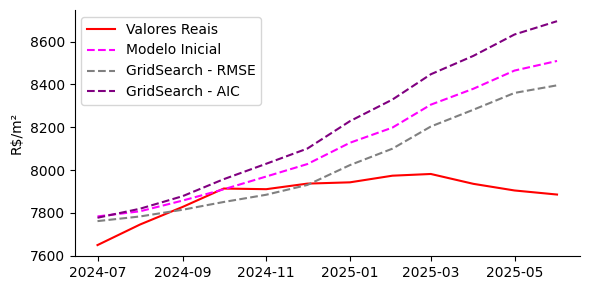

In [100]:
# Criar figura
plt.figure(figsize=(6, 3))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')

# Plotar valores previstos
plt.plot(y_test.index, y_pred_init_sarimax, '--', color='magenta', label='Modelo Inicial')
plt.plot(y_test.index, y_pred_gs_rmse, '--',color='grey', label='GridSearch - RMSE')
plt.plot(y_test.index, y_pred_aic, '--', color='purple', label='GridSearch - AIC')

# Opções dos eixos
plt.ylabel('R$/m²', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

# Legedas
plt.legend()

# Tirar eixos paralelos
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar gráfico
plt.tight_layout()
plt.show()

# 3. Modelo XGBoost

## 3.1 Tratamentos iniciais

In [223]:
# Exclui  NA
df_xgb = df_pre_pro.dropna()

In [224]:
# Criando variaveis com lag
lags =  3 # Lag

# Lag features
X = df_xgb.copy()
for col in X.columns.tolist():
    for lag in range(1, lags + 1):
        X[f'{col}_lag_{lag}'] = X[col].shift(lag)

In [225]:
# Excluir variaivel orginais deixando apenas defasadas
X = X.drop(columns=df_xgb.columns.tolist())

In [226]:
# Remove linhas com NaN (criadas pelos lags)
X_xgb = X.diff().dropna()
X_xgb.head()

,go_price_lag_1,go_price_lag_2,go_price_lag_3,tx_juros_lag_1,tx_juros_lag_2,tx_juros_lag_3,ipca_lag_1,ipca_lag_2,ipca_lag_3,renda_med_lag_1,...,ic_agro_lag_3,inadim_imob_lag_1,inadim_imob_lag_2,inadim_imob_lag_3,vol_cred_lag_1,vol_cred_lag_2,vol_cred_lag_3,sald_cred_lag_1,sald_cred_lag_2,sald_cred_lag_3
date,,,,,,,,,,,,,,,,,,,,,
2014-05-01,70.842366,52.360131,27.865400,-0.12,0.15,0.54,0.126687,0.473334,0.094460,-3.0,...,6.91,0.143054,0.000791,0.116306,-549.0,-1276.0,2942.0,8660.0,8025.0,7891.0
2014-06-01,40.977896,70.842366,52.360131,0.18,-0.12,0.15,0.095299,0.126687,0.473334,-4.0,...,2.59,0.075217,0.143054,0.000791,2698.0,-549.0,-1276.0,11183.0,8660.0,8025.0
2014-07-01,36.911115,40.977896,70.842366,-0.13,0.18,-0.12,0.148539,0.095299,0.126687,-17.0,...,-4.52,-0.193184,0.075217,0.143054,-1727.0,2698.0,-549.0,9741.0,11183.0,8660.0
2014-08-01,42.750515,36.911115,40.977896,0.24,-0.13,0.18,-0.021298,0.148539,0.095299,-6.0,...,-3.20,0.026069,-0.193184,0.075217,645.0,-1727.0,2698.0,9729.0,9741.0,11183.0
2014-09-01,66.678193,42.750515,36.911115,-0.09,0.24,-0.13,0.010625,-0.021298,0.148539,19.0,...,-1.98,0.037009,0.026069,-0.193184,-810.0,645.0,-1727.0,9479.0,9729.0,9741.0


In [227]:
# Definir variavel dependente
y_xgb = df_xgb['go_price']

# Remover primeira linha, devido ao lag realizado em X
y_xgb = y_xgb.drop(pd.Timestamp("2014-01-01"))

In [228]:
# Diferenciação em y
y_xgb_diff = y_xgb.diff().dropna()
y_xgb_diff.head()

,go_price
date,
2014-03-01,52.360131
2014-04-01,70.842366
2014-05-01,40.977896
2014-06-01,36.911115
2014-07-01,42.750515


In [229]:
# Igual tamanho devido as perndas com defasagem (lag=3)
#y_xgb_diff = y_xgb_diff.drop(pd.Timestamp("2014-02-01"))
y_xgb_diff = y_xgb_diff.drop(pd.Timestamp("2014-03-01"))
y_xgb_diff = y_xgb_diff.drop(pd.Timestamp("2014-04-01"))
#y_xgb_diff = y_xgb_diff.drop(pd.Timestamp("2014-05-01"))

In [230]:
# Dividir em teste e treino
X_train, X_test = X_xgb.iloc[:-test_size], X_xgb.iloc[-test_size:]
y_train, y_test = y_xgb_diff.iloc[:-test_size], y_xgb_diff.iloc[-test_size:]

## 3.2 XGBoost Inicial

In [237]:
# Instanciar modelo
model_xgb_init = xgb.XGBRegressor(
        learning_rate=0.01,
        max_depth=5,
        n_estimators=100,
        random_state=42
    )

# Treinar modelo
model_xgb_init = model_xgb_init.fit(X_train, y_train)

# ====== TESTE =======
# Previsão
y_pred_xgb_init_test = model_xgb_init.predict(X_test)

# Retornando diferenciação
y_reconst1 = y_pred_xgb_init_test.cumsum() # diff1

# Terminando o retorno da diferenciação
y_pred_xgb_init_test = y_reconst1 + y_true_test[0]

# Erro no teste
rmse_test_init = np.sqrt(mean_squared_error(y_true_test, y_pred_xgb_init_test))


# ===== TREINO =======
#Previsão
y_pred_xgb_init_train = model_xgb_init.predict(X_train)


# Retornando diferenciação
y_reconst1 = y_pred_xgb_init_train.cumsum() # diff1

# Retorno do real no treino
y_true_train = y_xgb.iloc[:len(y_train)]

# Terminando o retorno da diferenciação
y_pred_xgb_init_train = y_reconst1 + y_true_train[0]

# Erro no treino
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_xgb_init_train))

# ==== RESULTADOS ======
print(f"RMSE Teste: {rmse_test_init:.2f} | RMSE Treino: {rmse_train:.2f}")

RMSE Teste: 107.11 | RMSE Treino: 401.68


In [238]:
y_true_train.shape

(122,)

In [239]:
y_pred_xgb_init_train.shap

(122,)

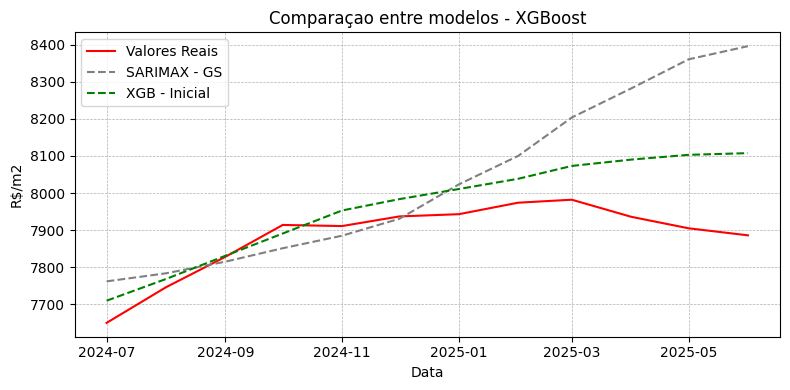

In [241]:
# Criar figura
plt.figure(figsize=(8, 4))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')
plt.plot(y_test.index, y_pred_gs_rmse, '--',color='grey', label='SARIMAX - GS')
plt.plot(y_test.index, y_pred_xgb_init_test, '--',color='green', label='XGB - Inicial')

# Configurações do gráfico
plt.title('Comparaçao entre modelos - XGBoost')
plt.xlabel('Data')
plt.ylabel('R$/m2')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

## 3.3 XGBoost GridSearch

In [282]:
param_grid = {
    "learning_rate": [0.01, 0.005, 0.003],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 300, 500]
}

# Gerar todas as combinações possíveis
param_combinations = list(itertools.product(
    param_grid["learning_rate"],
    param_grid["max_depth"],
    param_grid["n_estimators"]
))

best_params = None
best_rmse = float("inf")



In [283]:
# Para cada grid
for params in param_combinations:
    lr, md, ne = params
    rmse_test_scores = []
    rmse_train_scores = []

    # Instanciado o modelo
    model_xgb_gs = xgb.XGBRegressor(
          learning_rate=lr,
          max_depth=md,
          n_estimators=ne,
          random_state=42
      )

    # Treinar
    model_xgb_gs.fit(X_train, y_train)


    # ======= TESTE ========
    # Prever
    y_pred_xgb_gs_test = model_xgb_gs.predict(X_test)

    # Retornando diferenciação
    y_reconst1 = y_pred_xgb_gs_test.cumsum()
    y_pred_xgb_gs_test = y_reconst1 + y_true_test[0]

    # Erro
    rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_xgb_gs_test))
    rmse_test_scores.append(rmse) # Adicionar na lista


    # ======= TREINO ========
    # Prever
    y_pred_xgb_gs_train = model_xgb_gs.predict(X_train)

    # Retornando diferenciação
    y_reconst1 = y_pred_xgb_gs_train.cumsum() # diff1

    # Retorno do real no treino
    y_true_train = y_xgb.iloc[:len(y_train)]

    # Terminando o retorno da diferenciação
    y_pred_xgb_gs_train = y_reconst1 + y_true_train[0]

    #Erro
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_xgb_gs_train))
    rmse_train_scores.append(rmse_train)

    # RMSE médio da combinação
    mean_rmse_test = np.mean(rmse_test_scores)
    mean_rmse_train = np.mean(rmse_train_scores)

    print(f"Params: lr={lr}, depth={md}, n_estimators={ne} "
          f"| RMSE teste: {mean_rmse_test:.2f} | RMSE treino: {mean_rmse_train:.2f}")

    # Guardar melhor combinação
    if mean_rmse_test < best_rmse:
          best_rmse = mean_rmse_test
          best_params = (lr, md, ne)

# RMSE médio
print(f"\nRMSE teste: {np.mean(rmse_test_scores):.2f} RMSE treino: {np.mean(rmse_train_scores):.2f} ")

print(f"\n Melhor combinação: lr={best_params[0]}, depth={best_params[1]}, "
      f"n_estimators={best_params[2]} | RMSE teste: {best_rmse:.2f}")

Params: lr=0.01, depth=3, n_estimators=100 | RMSE teste: 110.10 | RMSE treino: 408.07
Params: lr=0.01, depth=3, n_estimators=300 | RMSE teste: 162.39 | RMSE treino: 103.46
Params: lr=0.01, depth=3, n_estimators=500 | RMSE teste: 168.29 | RMSE treino: 94.97
Params: lr=0.01, depth=5, n_estimators=100 | RMSE teste: 111.45 | RMSE treino: 401.33
Params: lr=0.01, depth=5, n_estimators=300 | RMSE teste: 154.66 | RMSE treino: 105.14
Params: lr=0.01, depth=5, n_estimators=500 | RMSE teste: 167.45 | RMSE treino: 102.72
Params: lr=0.01, depth=7, n_estimators=100 | RMSE teste: 107.85 | RMSE treino: 408.59
Params: lr=0.01, depth=7, n_estimators=300 | RMSE teste: 140.87 | RMSE treino: 109.93
Params: lr=0.01, depth=7, n_estimators=500 | RMSE teste: 148.08 | RMSE treino: 104.30
Params: lr=0.005, depth=3, n_estimators=100 | RMSE teste: 85.65 | RMSE treino: 651.55
Params: lr=0.005, depth=3, n_estimators=300 | RMSE teste: 127.13 | RMSE treino: 257.37
Params: lr=0.005, depth=3, n_estimators=500 | RMSE tes

In [273]:
# Instanciar modelo
model_xgb_best = xgb.XGBRegressor(
        learning_rate=0.01,
        max_depth=3,
        n_estimators=500,
        random_state=42
    )

# Treinar modelo
model_xgb_best = model_xgb_best.fit(X_train, y_train)

# ====== TESTE =======
# Previsão
y_pred_xgb_best_test = model_xgb_best.predict(X_test)

# Retornando diferenciação
y_reconst1 = y_pred_xgb_best_test.cumsum() # diff1

# Terminando o retorno da diferenciação
y_pred_xgb_best_test = y_reconst1 + y_true_test[0]

# Erro no teste
rmse_test_best = np.sqrt(mean_squared_error(y_true_test, y_pred_xgb_best_test))


# ===== TREINO =======
#Previsão
y_pred_xgb_best = model_xgb_best.predict(X_train)


# Retornando diferenciação
y_reconst1 = y_pred_xgb_best.cumsum() # diff1

# Retorno do real no treino
y_true_train = y_xgb.iloc[:len(y_train)]

# Terminando o retorno da diferenciação
y_pred_xgb_best = y_reconst1 + y_true_train[0]

# Erro no treino
rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_xgb_best))

# ==== RESULTADOS ======
print(f"RMSE Teste: {rmse_test_best:.2f} | RMSE Treino: {rmse_train:.2f}")

RMSE Teste: 169.15 | RMSE Treino: 99.60


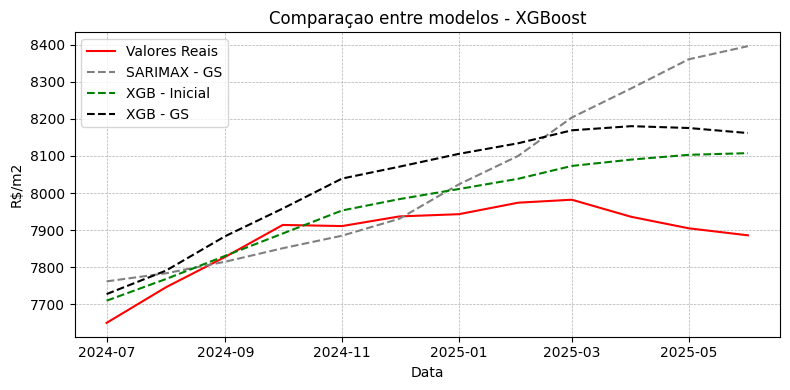

In [274]:
# Criar figura
plt.figure(figsize=(8, 4))

# Plotar valores reais
plt.plot(y_test.index, y_true_test, 'r-', label='Valores Reais')
plt.plot(y_test.index, y_pred_gs_rmse, '--',color='grey', label='SARIMAX - GS')
plt.plot(y_test.index, y_pred_xgb_init_test, '--',color='green', label='XGB - Inicial')
plt.plot(y_test.index, y_pred_xgb_best_test, '--',color='black', label='XGB - GS')

# Configurações do gráfico
plt.title('Comparaçao entre modelos - XGBoost')
plt.xlabel('Data')
plt.ylabel('R$/m2')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

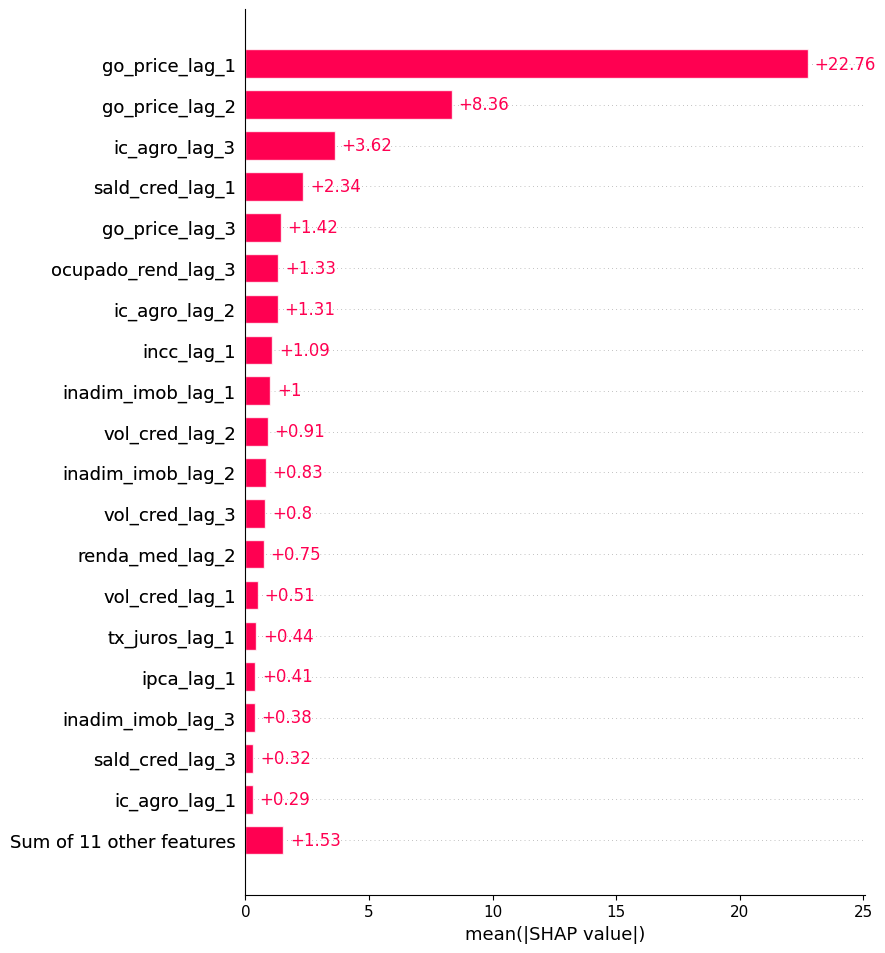

In [276]:
import shap

explainer = shap.Explainer(model_xgb_best)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=20)  # Gráfico de importância global|

# 4. LSTM